# RadioML Receiver

### A Recurrent Neural Network for Learning to demodulate and decode noisy signals over AWGN Channel.

___

# Environment Setup

Download & install and import packages for this tutorial


In [1]:
# Import local module
import time
import os
import sys
# a hack to import module from different directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing as mp
import random 
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

# For baseline comparision
from radioml.demodulators import ClassicDemodulator
from radioml.decoders import ViterbiDecoder
from radioml.radio_receivers import ModularReceiver, End2EndReceiver
import radioml.utils as radioml_utils

# For end2end receiver
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional, TimeDistributed

# For visualization
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

print("\nEnvironment setup is completed.")


Environment setup is completed.


# Define parameters for this experiment

In [2]:
DATA_LENGTH  = 100
DATA_RATE    = 1/2
SNR_TRAIN    = 10.0 

SNR          = SNR_TRAIN 

modem = QAMModem(4) 
trellis = Trellis(memory   = np.array([2]), 
                  g_matrix = np.array([[0o7, 0o5]]) , 
                  feedback = 0o7)

# Dataset Prepartion

## Define functions for data generator/transformation.


In [3]:
def generate_signal_over_awgn(modem, data_length=100, snr_dB=15.0):
    """Simulate Data sending over AWGN Channel."""
    
    message_bits   = np.random.randint(0, 2, data_length)
    encoded_bits   = cp.channelcoding.conv_encode(message_bits, trellis)
    modulated_bits = modem.modulate(encoded_bits)
    corrupted_bits = cp.channels.awgn(modulated_bits, snr_dB, rate=1/2)
    return message_bits, modulated_bits, corrupted_bits
 
def get_trainable_data(x, y):
    """Encode complex numbers to trainable data and one_hot labels"""
    x = np.array(x)[:, :100]
    y = np.array(y)
    x = np.stack((x.real, x.imag), axis=-1)
    y = np.expand_dims(y, -1)  # (batch, data_length, 1)
    return x, y

def signal_generator(modulation_scheme, num_examples, data_length, snr_dB, 
                     seed=2018):
    """A generator to generate NUM_SAMPLES data points."""
    
    np.random.seed(seed)
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.starmap(generate_signal_over_awgn,
                iterable=[(modulation_scheme, data_length, snr_dB) \
                          for i in range(num_examples)])
        orignal_msg_bits, moded_bits, noisy_outputs = zip(*result)
    np.random.seed()
    return (np.array(orignal_msg_bits), np.array(moded_bits), np.array(noisy_outputs))

## Generate dev/test dataset


Training data
Trainable data: (10000, 100, 2)
Groundtruths  : (10000, 100, 1)



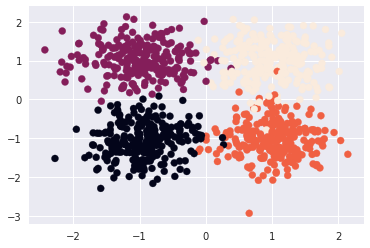

In [4]:
# Generate data for training
original_bits, clean_signals, noisy_signals = signal_generator(modem, 10000, DATA_LENGTH, SNR)

# Split data into train/dev/test
dataset = list(zip(noisy_signals, original_bits))

# Split data
x_dev, y_dev = zip(*dataset)
X_dev, Y_dev = get_trainable_data(x_dev, y_dev)

print('Training data')
print('Trainable data:', X_dev.shape)
print('Groundtruths  :', Y_dev.shape)
print()

## Visualize a subset of data
inputs = noisy_signals.flatten()[0:1000]
_, groundtruths = np.unique(clean_signals, return_inverse=True)
_ = plt.scatter(np.real(inputs), np.imag(inputs), c=groundtruths[0:1000])

#  Compute baseline performance (Classic Demodulation + Viterbi)


In [5]:
baseline_receiver = ModularReceiver(
    ClassicDemodulator(modem),
    ViterbiDecoder(trellis, tb_depth=15))

with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_dev])

ber, bler = radioml_utils.get_ber_bler(np.array(baseline_estimated)[:, :100], y_dev)
print('Optimal BER: %.4f' % ber)
print('Optimal BLER: %.5f' % bler)

Optimal BER: 0.0005
Optimal BLER: 0.02480


 # Construct a Recurrent  Neural Network (2-layer Bidirectional GRU )
 
 
Here we implement an RNN that will read encoded complex inputs and estimate the orignal message bits

In [6]:
num_hidden_layers = 2
hidden_units = 400
dropout = 0.3

# To avoid accidenttally run this cell multiple times.
tf.keras.backend.clear_session()

inputs  = Input(shape=(None, 2))
x = inputs
# Network Architecture
for _ in range(num_hidden_layers):
    x = Bidirectional(GRU(hidden_units,return_sequences=True, recurrent_dropout=dropout))(x)
    x = BatchNormalization()(x)
outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 800)         967200    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 800)         3200      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 800)         2882400   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 800)         3200      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           801       
Total params: 3,856,801
Trainable params: 3,853,601
Non-trainable params: 3,200
______________________________________________________________

## Define Loss Function / Metrics (BER/BLER) for training.

In [7]:
def BLER(y, y_pred):
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int64)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.count_nonzero(tf.reduce_sum(hamming_distances, axis=1)) \
            / num_blocks_per_batch

model.compile('adam','binary_crossentropy', metrics=[BLER])

In [8]:
def generate_unlimited_data(batch_size=128):
    while True:
        batch = [generate_signal_over_awgn(modem, DATA_LENGTH, SNR_TRAIN) \
                   for i in range(batch_size)]
        labels, _, inputs  = zip(*batch)
        x, y = get_trainable_data(inputs, labels)
        yield x, y

early_stopping = tf.keras.callbacks.EarlyStopping(
    'val_BLER', patience=2)

model.fit_generator(
    generator= generate_unlimited_data(256),
    steps_per_epoch=100,
    validation_data=(X_dev, Y_dev),
    callbacks=[early_stopping],
    epochs=50)

Epoch 1/50
100/100 [==============================] - 73s 728ms/step - loss: 0.0541 - BLER: 0.6689 - val_loss: 0.2881 - val_BLER: 0.9928
Epoch 2/50
100/100 [==============================] - 65s 654ms/step - loss: 0.0093 - BLER: 0.2542 - val_loss: 0.1585 - val_BLER: 0.9312
Epoch 3/50
100/100 [==============================] - 68s 683ms/step - loss: 0.0042 - BLER: 0.1231 - val_loss: 0.0655 - val_BLER: 0.7029
Epoch 4/50
100/100 [==============================] - 68s 675ms/step - loss: 0.0036 - BLER: 0.1094 - val_loss: 0.0135 - val_BLER: 0.2477
Epoch 5/50
100/100 [==============================] - 76s 757ms/step - loss: 0.0032 - BLER: 0.0998 - val_loss: 0.0042 - val_BLER: 0.1168
Epoch 6/50
100/100 [==============================] - 72s 720ms/step - loss: 0.0029 - BLER: 0.0891 - val_loss: 0.0028 - val_BLER: 0.0848
Epoch 7/50
100/100 [==============================] - 77s 772ms/step - loss: 0.0025 - BLER: 0.0759 - val_loss: 0.0020 - val_BLER: 0.0592
Epoch 8/50
100/100 [=====================

# Evaluate on Test Set (100K data points) at $SNR_{train}$

In [9]:
# Generate data for training
original_bits, clean_signals, noisy_signals = signal_generator(modem, 100000, DATA_LENGTH, SNR)

# Split data into train/dev/test
dataset = list(zip(noisy_signals, original_bits))

# Split data
x_test, y_test = zip(*dataset)
X_test, Y_test = get_trainable_data(x_test, y_test)


# ############################
# Baseline Receiver
# ############################
with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i for i in x_test])
    
print('[Baseline]    BER = %.8f, BLER = %.8f' % \
      radioml_utils.get_ber_bler(np.array(baseline_estimated)[:, :100], y_test))

# ############################
# ML Receiver
# ############################
predictions = model.predict(X_test, batch_size=512)
ml_estimated = np.squeeze(predictions, -1).round()

print('[ML Receiver] BER = %.8f, BLER = %.8f' % \
      radioml_utils.get_ber_bler(ml_estimated, y_test))


[Baseline]    BER = 0.00035520, BLER = 0.01904000
[ML Receiver] BER = 0.00004080, BLER = 0.00368000


# Evaluate on multiple $SNRs$.

In [12]:
model.save('end2end.hdf5')

end2end_receiver = End2EndReceiver('end2end.hdf5', data_length=100)

class Params:
    SNR_RANGE = [0.0, 3.0, 5.0, 7.0, 9.0, 10.0, 11.0, 13.0]
    NUM_SAMPLES = 10000
    BLOCK_LENGTH = 100
    BPSK, QPSK, QAM16, QAM64 = 2, 4, 16, 64
    
ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    print('SNR_dB = %f' % snr)
    (original_bits, _, noisy_signals) = signal_generator(
        modem, Params.NUM_SAMPLES, Params.BLOCK_LENGTH, snr)
    
    # Run Baseline/Neral Receiver
    t1 = time.time()
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimated = pool.map(baseline_receiver, [i for i in noisy_signals])
        
    t2 = time.time()
    
    nn_estimated = end2end_receiver(np.array(noisy_signals)[:, :100], 128)
    
    t3 = time.time()
    
    # Measure BER / BKER for two receivers
    ber, bler = radioml_utils.get_ber_bler(np.array(baseline_estimated)[:, :100], original_bits)
    nn_ber, nn_bler = radioml_utils.get_ber_bler(nn_estimated, original_bits)
    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(nn_ber, nn_bler, t3 - t2))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(ber, bler, t2-t1))
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])
    

SNR_dB = 0.000000
	[Modular]  Ber = 0.23190400 | Bler =1.00000000 - 8.05234s
	[Baseline] Ber = 0.28347100 | Bler =1.00000000 - 40.36711s
SNR_dB = 3.000000
	[Modular]  Ber = 0.11208700 | Bler =1.00000000 - 8.00770s
	[Baseline] Ber = 0.16619700 | Bler =0.99920000 - 40.07659s
SNR_dB = 5.000000
	[Modular]  Ber = 0.03852400 | Bler =0.90250000 - 6.87620s
	[Baseline] Ber = 0.07521200 | Bler =0.92170000 - 39.77989s
SNR_dB = 7.000000
	[Modular]  Ber = 0.00555400 | Bler =0.32450000 - 6.82436s
	[Baseline] Ber = 0.01582400 | Bler =0.40750000 - 39.79702s
SNR_dB = 9.000000
	[Modular]  Ber = 0.00028000 | Bler =0.02000000 - 6.87198s
	[Baseline] Ber = 0.00152800 | Bler =0.06000000 - 40.07055s
SNR_dB = 10.000000
	[Modular]  Ber = 0.00004800 | Bler =0.00320000 - 7.27788s
	[Baseline] Ber = 0.00054400 | Bler =0.02480000 - 43.61095s
SNR_dB = 11.000000
	[Modular]  Ber = 0.00000800 | Bler =0.00080000 - 6.90145s
	[Baseline] Ber = 0.00008000 | Bler =0.00560000 - 40.69749s
SNR_dB = 13.000000
	[Modular]  Ber = 0.

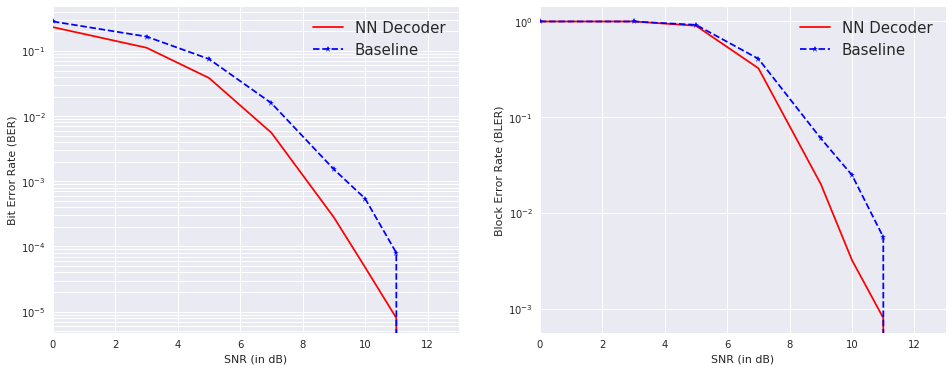

In [16]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
radioml_utils.visualize_ber_bler(ax1, ax2, ber_logs, bler_logs, Params.SNR_RANGE)
ax1.semilogy()
_=ax2.semilogy()